# Configuration model (CM)

In [1]:
import networkx as nx
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
from scipy import stats # to do regression for the estimation of the exponent
from scipy.stats import poisson

ModuleNotFoundError: No module named 'network_utils'

Insert distribution parameter

In [5]:
# name of the model file
N = 500
gamma = 2
model_name = f"nets/CM_powerlaw_gamma{gamma}_n{N}.net"

Now, let's build the degrees list according to the chosen probability distribution

In [6]:
sequence = [1] # degrees list initialized with a 1 to execute the loop

# The degree sequence needs to have an even sum
while sum(sequence) % 2 != 0:
    sequence = []
        
    # Limit the number of self-loops and multiple edges in case of gamma between 2 and 3
    if gamma >= 2 and gamma <=3: 
        k_max = round(math.sqrt(N)) # limit the maximum degree of each node to the square root of N
        
        # generate dhe degree for each node
        for i in range(N):
            prob = float(nx.utils.powerlaw_sequence(n = 1,exponent=gamma)[0])
            deg = int(round(prob))
            
            # re-generate the degree if it's above the above defined threshold
            while deg > k_max:
                prob = float(nx.utils.powerlaw_sequence(1,exponent=gamma)[0])
                deg = int(round(prob))
            sequence.append(deg) # add degree to the degrees list
    else:         
        seq=nx.utils.powerlaw_sequence(N,exponent=gamma)
        # round to integer values in the range [0,N]
        sequence = [min(N, max( int(round(s)),0 )) for s in seq]

      
print("Lenght of the sequence: {}".format(len(sequence)))
print("\nSequence of node degrees (first 50 nodes):\n {}".format(sequence[:50]))

Lenght of the sequence: 10000

Sequence of node degrees (first 50 nodes):
 [2, 4, 3, 1, 1, 1, 3, 1, 1, 1, 2, 2, 1, 5, 2, 1, 2, 1, 1, 1, 4, 1, 1, 1, 6, 4, 1, 1, 2, 1, 15, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2]


## Algorithm
We need now to build a random graph/network with this degree sequence. <br>
Let's build before an empty graph of type MultiGraph, which allows self-loops and multiple edges and then we'll remove them

In [7]:
G = nx.empty_graph(N, create_using = nx.MultiGraph) # MultiGraph because of self-loops

Let's create the list of "stubs", i.e. a list of available degree-repeated nodes. 

In [8]:
#stubs_list = list(chain.from_iterable([n] * d for n, d in enumerate(sequence)))
stubs_list = []
for i in range(N):
    stubs_list += [i for _ in range(sequence[i])]

print(stubs_list[1:50])

[0, 1, 1, 1, 1, 2, 2, 2, 3, 4, 5, 6, 6, 6, 7, 8, 9, 10, 10, 11, 11, 12, 13, 13, 13, 13, 13, 14, 14, 15, 16, 16, 17, 18, 19, 20, 20, 20, 20, 21, 22, 23, 24, 24, 24, 24, 24, 24, 25]


Shuffle the "stubs" list, i.e. perform a random permutation

In [9]:
np.random.shuffle(stubs_list)
print(stubs_list[1:50])

[5133, 6089, 2940, 4323, 44, 1762, 7892, 2611, 1676, 721, 8549, 4628, 1043, 1796, 776, 5948, 1258, 2485, 550, 6738, 6349, 2442, 4282, 8311, 4003, 4673, 4303, 1634, 4544, 7539, 8509, 9116, 8242, 4852, 6548, 2238, 9501, 4290, 7704, 8837, 7454, 7793, 8895, 4086, 3115, 8356, 76, 3065, 854]


Now we need to creade edges among the nodes in the "stubs" list. We could use two different options:
* A first option could be to bipartition the shuffled slot vector to have a random pairing of nodes. This allows to use the add_edges_from function of networkx that creates links between the 2 partitions<br>

In [10]:
#half = len(slots) // 2

#out_slots, in_slots = stubs_list[:half],stubs_list[half:]
#G.add_edges_from(zip(out_slots, in_slots)) # with zip we create a series of tuples from the 2 lists

* The 2nd option, that is the one we use, is to add edges between consecutive pairs of nodes in the shuffled list <br>

In [11]:
for i in range(0, len(stubs_list), 2):
    G.add_edge(stubs_list[i], stubs_list[i+1])

### Parallel edges and self-loops
Let's first check the presence of self-loops

In [12]:
# number of self-loops
nx.number_of_selfloops(G)

1

In [13]:
# nodes with a self-loop
list(nx.nodes_with_selfloops(G))

[6124]

Multiple edges

In [14]:
arr = nx.to_numpy_matrix(G)
num_multiedges = np.sum(arr>=2) / 2 # divide by two as graph is undirected 
num_multiedges

4.0

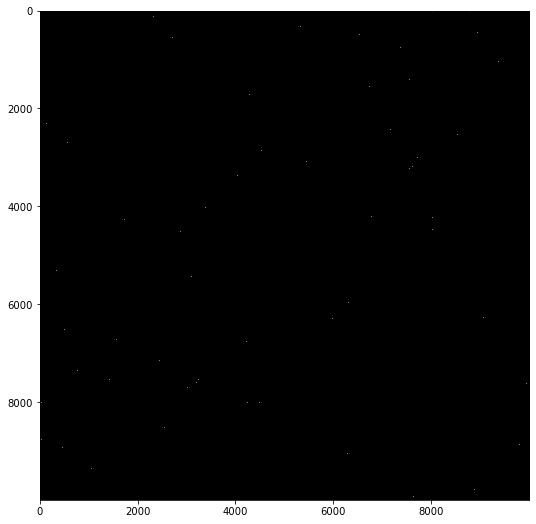

In [15]:
# Visualize multiple edges
plt.figure(figsize=(16,9))
plt.imshow(arr, interpolation='nearest', cmap='gray')
plt.show()

Remove parallel edges and self-loops

In [16]:
G = nx.Graph(G) # removes parallel edges
G.remove_edges_from(nx.selfloop_edges(G)) # removes selfloops

arr = nx.to_numpy_matrix(G)
num_multiedges = np.sum(arr>=2) / 2 # divide by two as graph is undirected 


nx.number_of_selfloops(G), int(num_multiedges)

(0, 0)

### Save the network

In [17]:
nx.write_pajek(G, model_name)
#nx.write_gexf(G, "test.gexf")

## Network descriptors

In [18]:
print("Number of nodes: {}".format(G.number_of_nodes()))
#G.nodes()

print("Number of edges: {}".format(G.number_of_edges()))
#G.edges()

degrees_values = [val for key,val in G.degree()] # degree for each node
#degrees_values

print("Min degree: {}".format(np.min(degrees_values)))
print("Max degree: {}".format(np.max(degrees_values)))
print("Avg degree: {}".format(round(np.mean(degrees_values), 4)))
#G = nx.Graph(G)

print("Clustering: {}".format(round(nx.average_clustering(G), 4)))
print("Assortativity: {}".format(round(nx.degree_assortativity_coefficient(G), 4)))
if nx.is_connected(G):
    print("Avg path length: {}".format(round(nx.average_shortest_path_length(G), 4)))
    print("Diameter: {}".format(nx.diameter(G)))

Number of nodes: 10000
Number of edges: 10015
Min degree: 1
Max degree: 86
Avg degree: 2.003
Clustering: 0.0005
Assortativity: -0.012
